# HW 10 CLUSTERING BUSINESS

In [1]:
import os
import pandas as pd
import geopandas as gpd
import zipfile 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist, pdist
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#!for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done
for y in range(1993,2016):
    filename = 'zbp'+str(y)[2:]+'totals.zip'

    if y <= 2001:
        os.system('wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/' + filename)
    else: 
        os.system('wget ftp://ftp.census.gov/econ' + str(y) + '/CBP_CSV/' + filename)
    print filename
    os.system('mv '+filename + ' ' + os.getenv("PUIDATA") + '/ecoCensus/')

NOTES: 
to read in a zip file without unzipping it you can use the pandas and zipfile packages

In [21]:
filename = 'nyc-zip-code-tabulation-areas-polygons.geojson'

In [45]:
#ZIPCODES

url = 'https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/HW11_fb55/'
filename = 'nyc-zip-code-tabulation-areas-polygons.geojson'
os.system('wget '+ url + filename)

os.system('mv ' + filename + ' ' + os.getenv("PUIDATA"))

0

In [22]:
zipcodes = gpd.read_file(os.getenv("PUIDATA") +'/' + filename)
zipcodes = zipcodes.loc[:,['OBJECTID','PO_NAME','borough','geometry','postalCode']]
zipcodes.postalCode = zipcodes.postalCode.astype(int)

In [46]:
zipcodes.head()

,OBJECTID,PO_NAME,borough,geometry,postalCode
0,1,Jackson Heights,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,2,Glen Oaks,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,3,New Hyde Park,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,4,Bellerose,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,5,Fresh Meadows,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [47]:
zipcodes.isnull().sum()

OBJECTID      0
PO_NAME       0
borough       0
geometry      0
postalCode    0
dtype: int64

In [48]:
f = []
for (dirpath, dirnames, filenames) in os.walk(os.getenv("PUIDATA") +'/ecoCensus/'):
    f.extend(filenames)
    break
f.sort()

In [49]:
years = range(2000,2015) + range(1994,2000)

In [50]:
mergeData = zipcodes.copy()
for i in range(len(f)):
    filename = f[i]
    zf = zipfile.ZipFile(os.getenv("PUIDATA") +'/ecoCensus/' + filename)
    df = pd.read_csv(zf.open(filename.replace('.zip','.txt')))
    #change this to upper case later
    try:
        df = df.loc[:,['ZIP','EST']]
    except KeyError:
        df = df.loc[:,['zip','est']]

    df.columns = ['postalCode',str(years[i])]
    #mergeData = zipcodes.copy()
    mergeData = pd.merge(left=mergeData,right=df,on = 'postalCode',how='left')
mergeData.loc[1:10,'2004':'1999']

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,1994,1995,1996,1997,1998,1999
1,226.0,225.0,226.0,238.0,227.0,233.0,229.0,222.0,241.0,241.0,250.0,194.0,188.0,176.0,192.0,194.0,186.0
2,1406.0,1441.0,1454.0,1488.0,1503.0,1475.0,1494.0,1488.0,1510.0,1539.0,1534.0,1422.0,1414.0,1335.0,1344.0,1344.0,1350.0
3,221.0,226.0,226.0,228.0,226.0,237.0,248.0,256.0,266.0,258.0,260.0,326.0,219.0,209.0,198.0,203.0,217.0
4,599.0,604.0,608.0,617.0,616.0,628.0,643.0,677.0,679.0,714.0,731.0,492.0,476.0,483.0,522.0,509.0,519.0
5,1418.0,1434.0,1442.0,1416.0,1460.0,1450.0,1498.0,1523.0,1554.0,1640.0,1650.0,1147.0,1172.0,1161.0,1189.0,1248.0,1242.0
6,670.0,685.0,690.0,681.0,682.0,681.0,690.0,714.0,714.0,718.0,723.0,669.0,669.0,656.0,641.0,644.0,635.0
7,2010.0,2057.0,2046.0,2064.0,2034.0,2052.0,2060.0,2102.0,2078.0,2124.0,2110.0,1868.0,1925.0,1957.0,1926.0,1949.0,1975.0
8,224.0,230.0,223.0,220.0,222.0,219.0,237.0,248.0,245.0,259.0,276.0,170.0,172.0,176.0,187.0,192.0,203.0
9,1051.0,1093.0,1086.0,1072.0,1057.0,1086.0,1089.0,1108.0,1081.0,1119.0,1118.0,830.0,831.0,839.0,833.0,869.0,897.0
10,367.0,381.0,393.0,403.0,409.0,430.0,449.0,432.0,453.0,467.0,461.0,329.0,328.0,347.0,372.0,363.0,369.0


In [51]:
for i in range(mergeData.shape[0]):
    mergeData.iloc[i,5:] = (mergeData.iloc[i,5:] - mergeData.iloc[i,5:].mean()) / mergeData.iloc[i,5:].std()


In [52]:
yearsText = years
yearsText.sort()
yearsText = map(lambda x: str(x), yearsText)

In [53]:
mergeData.loc[:,yearsText].head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,-1.650515,-1.607088,-1.259673,-1.154208,-0.893647,-0.738551,-0.533825,-0.540029,-0.198818,0.161004,...,0.272673,0.198227,0.309896,0.266469,0.477400,0.831018,0.942687,1.420382,1.637516,1.693350
1,-0.974535,-1.248013,-1.794968,-1.065695,-0.974535,-1.339172,-1.202433,-0.518739,-0.062943,0.575171,...,0.438432,0.484012,1.030967,0.529592,0.803069,0.620751,0.301694,1.167706,1.167706,1.577923
2,-0.118051,-0.234030,-1.379327,-1.248850,-1.248850,-1.161866,-1.161866,-1.292342,-0.465989,-0.393502,...,0.157401,0.345867,0.838780,1.056241,0.650313,0.925765,0.838780,1.157723,1.578149,1.505662
3,3.212291,-0.444253,-0.785986,-1.161892,-0.991026,-0.512600,-0.649293,-0.512600,-0.854333,-0.717639,...,-0.205040,-0.205040,-0.136693,-0.205040,0.170867,0.546773,0.820159,1.161892,0.888506,0.956853
4,-1.332578,-1.549090,-1.454366,-0.926619,-1.102534,-0.967215,-0.507127,-0.222956,-0.222956,-0.114700,...,0.183004,0.237132,0.358920,0.345388,0.507772,0.710751,1.170839,1.197903,1.671522,1.901566


In [54]:
X = np.matrix(mergeData.loc[:,yearsText])
X = np.where(np.isnan(X),0,X)


In [56]:
X.shape

(262, 21)

In [57]:
maxK = 10

for n_clusters in range(2,maxK):
    #run the clustering
    km = KMeans(n_clusters=n_clusters, random_state=123)
    #assign labels of clusters
    cluster_labels = km.fit_predict(X)
    #calculate average for each cluster
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.530148169977
For n_clusters =3, the average silhouette_score is :0.495485291471
For n_clusters =4, the average silhouette_score is :0.472800472998
For n_clusters =5, the average silhouette_score is :0.256266988354
For n_clusters =6, the average silhouette_score is :0.153290960947
For n_clusters =7, the average silhouette_score is :0.26439791611
For n_clusters =8, the average silhouette_score is :0.207028893901
For n_clusters =9, the average silhouette_score is :0.159829558011


In [58]:
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

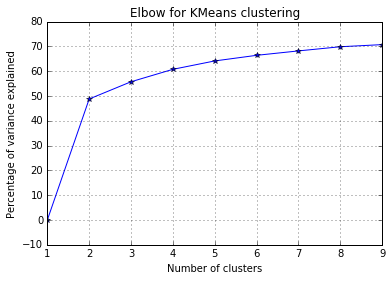

In [59]:
elbow(X, range(1,10))

## Figure 1
The plot shows the percentage of variance explained by que amount of clusters. While 2 clusters explain almost 50 % of variance, but nothing more is to be gained by choosing more clusters.

In [62]:

#train the model.
km2=KMeans(random_state=324,n_clusters=2)
res2=km2.fit(X)

mergeData['k2'] = res2.labels_ 


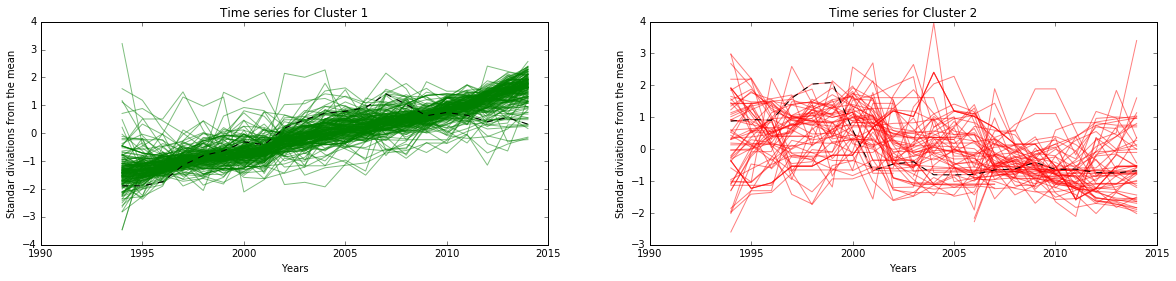

In [71]:
zipsCluster0 = mergeData.loc[mergeData.k2==0].index
zipsCluster1 = mergeData.loc[mergeData.k2==1].index

fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

for i in zipsCluster0:
    ax1.plot(mergeData.loc[i,yearsText], color='green', alpha = .5)

ax1.plot(yearsText,[mergeData.loc[i,yearsText[j]].mean() for j in range(len(yearsText))],'k--')  
ax1.set_title('Time series for Cluster 1')
ax1.set_xlabel('Years')
ax1.set_ylabel('Standar diviations from the mean')

for i in zipsCluster1:
    ax2.plot(mergeData.loc[i,yearsText], color='red', alpha = .5)

ax2.plot(yearsText,[mergeData.loc[i,yearsText[j]].mean() for j in range(len(yearsText))],'k--',)
ax2.set_title('Time series for Cluster 2')
ax2.set_xlabel('Years')
ax2.set_ylabel('Standar diviations from the mean')



## Figure 2
The plot show the time series for the deviation from the mean for the zipcodes in each cluster. The first cluster's plot show that the amount of business in this cluster is increasing in time. The second cluster shows more erratic behaviour 

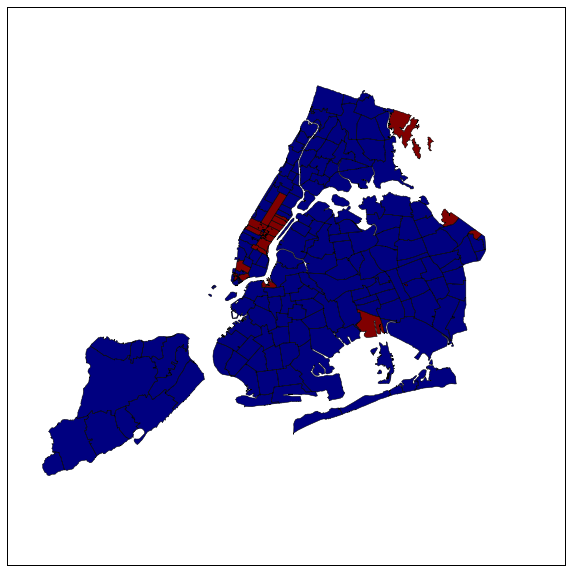

In [76]:
fig = plt.figure(figsize=(10,10)) 
ax1 = fig.add_subplot(1,1,1)

mergeData.plot(column = 'k2', alpha=1,linewidth=0.5,ax=ax1)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)


## Figure 4
Map with NYC zipcodes colored accordingly to the cluster. If we use 2 clusters, we should come with one group of zipcodes which has, in a consisten way across time, increasing amount of bussines. In the other hand, the other we would have zipcodes consistently below the mean in terms of amount of business. In red, the Midtown and Downtown area shows the zipcodes with increasing amount of business. 
